In [ ]:
!pip install pyts
!pip install --upgrade pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.impute import SimpleImputer
import sys
from scipy.fft import fft, dct
import pywt
from sklearn.preprocessing import LabelEncoder
np.set_printoptions(threshold=sys.maxsize)
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
import os
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from pyts.approximation import PiecewiseAggregateApproximation as PAA
from scipy.fftpack import idct

def generate_random_vectors(n, r):
    random_vectors = np.random.normal(0, 1, size=(r, n))
    return random_vectors

def MINE(data,R,R_inv):

  prod = np.matmul(data,R)
  bitmap = np.where(prod < 0, 0, 1)
  recon = np.matmul(bitmap,R_inv)
  return recon

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Number of windows')

    if type == 'SC' :
     ax.set_ylabel('Silhouette score')
     if method == 'RAW':
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'ARI' :
     ax.set_ylabel('ARI score')
     if method == 'RAW':
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig

def plot_score_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method

    y_axis_limits = (-1.5, 1.5)  # Outlier limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)

        # Identify and count outliers based on the limits
        outliers = np.where((y < -1.5) | (y > 1.5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))
        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'Silhouette scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}] ')
        ax.grid(True)

        # Set the y-axis limits to the predefined range
        ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig

def plot_ARI_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method
    y_axis_limits = (-1.5, 1.5) # Outlier limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)
        # Identify and count outliers based on the limits
        outliers = np.where((y < -1.5) | (y > 1.5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))

        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'ARI scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}]')
        ax.grid(True)

        # Set the y-axis limits to the predefined range
        ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# BROKEN,NORMAL,RECOVERING -> 0,0.5,1
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
max_label = df.iloc[:, -1].max()
df.iloc[:, -1] = df.iloc[:, -1] / max_label * 1.0
# Discard the first row + first two columns
df = df.iloc[:, 2:]
data = df.to_numpy(dtype='float')
# Split  features (X) and target (y)
X = data[:, :-1]
#print(X)
y = data[:, -1]
#print(y[0])
# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
# Select 1000 0.5 kai 1 labels
label_0_indices = np.where(y == 0)[0]
label_05_indices = np.where(y == 0.5)[0]
label_1_indices = np.where(y == 1)[0]
label_05_indices = np.random.choice(label_05_indices, size=1000, replace=False)
label_1_indices = np.random.choice(label_1_indices, size=1000, replace=False)
# Concatenate + shuffle
indices = np.concatenate((label_0_indices, label_05_indices, label_1_indices))
np.random.seed(123)   #Gia idio dataset shuffle se ola ta algorithms
np.random.shuffle(indices)
data = X[indices]
data = data.T

element_size_in_bytes = data[5][5].itemsize
element_size_in_bits = element_size_in_bytes * 8
#print(f"The bit size of x[0] is {element_size_in_bits} bits.")

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# KMeans
k = 2       #@param {type:"number"}
random_state = 0

#params
strides = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT', 'DCT', 'DWT', 'PAA','MINE']
n_features = scaled_data.shape[1]
all_labels = []  # create an empty list to store labels for all strides-ARI

#files for storing
folder_name = f"Kmeans new PUMP Measurements(k = {k})"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))

pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
 for stride in strides:

   silhouette_scores = []
   bad_clusters = 0
   subset_num = 0  #to accurately stroe labels for ARI

   for i in range(0, n_features-stride, stride):


      subset_length = min(stride, n_features-i)
      subset_data = scaled_data[:, i:i+subset_length]
      clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(subset_data)

      # store clustering results
      labels = clustering.labels_
      score = metrics.silhouette_score(subset_data , clustering.labels_)
      silhouette_scores.append(score)
      all_labels.append((stride, subset_num, labels))  # append the labels for this stride to all_labels
      subset_num = subset_num + 1
   #store plots
   methd = 'RAW'
   comprsn = 0
   fig = plot_confidence_interval(silhouette_scores,methd,stride,comprsn,'SC') #plot function call
   pdf.savefig(fig)
   plt.close(fig)
   # create a file name based on the method, subset index, stride, and compression
   avg_silhouette = np.mean(silhouette_scores)
   file_name = f"RAW DATA_stride({stride}).txt"
   # write the silhouette coefficients to file
   with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
    f.write(f"Average Silhouette Score: {avg_silhouette}\n")
    content = str(silhouette_scores)
    f.write(content)
    f.close()

for stride in strides:

    #file for storing
    stride_folder_name = f"stride({stride})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        # #vector and inverse vector arrays for our algorithm
        n = element_size_in_bits*int(stride/compression)  # Dimension of each random vector
        r = stride  # Number of random vectors to generate/rows
        R = generate_random_vectors(n, r)
        R_inv= np.linalg.pinv(R)
       # print(R.shape,R_inv.shape)

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)

        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
         results1 = []
         results2 = []
         for method in methods:

             slices = stride // compression
             silhouette_scores = []
             ARI_scores = []
             bad_clusters = 0
             num_subset = 0

             for i in range(0, n_features-stride, stride):
                 subset_length = min(stride, n_features-i)
                 subset_data = scaled_data[:, i:i+subset_length]
                 #vector and inverse vector arrays for our algorithm
                #  n = element_size_in_bits*int(stride/compression)  # Dimension of each random vector
                #  r = stride  # Number of random vectors to generate/rows
                #  R = generate_random_vectors(n, r)
                #  R_inv= np.linalg.pinv(R)

                 if method == 'DFT':

                       #array to store the restored data
                       compressed_subset_data = np.zeros_like(subset_data)

                       for i in range(51):
                          # Compute abs DFT of each row
                          dft_subset_data =  np.fft.fft(subset_data[i])
                          # Sort the DFT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dft_subset_data))[:slices]
                          sorted_dft_subset_data = dft_subset_data[sorted_indices]
                          # Keep  top  coeff
                          top__dft_subset_data = sorted_dft_subset_data[:slices]
                          #reconstruct the compressed dataset
                          compressed_subset_data[i] = np.fft.ifft(top__dft_subset_data,stride).real

                 elif method == 'DCT':

                       #array to store the restored data
                       compressed_subset_data = np.zeros_like(subset_data)

                       for i in range(51):
                          # Compute abs DCT of each row
                          dct_subset_data = dct(subset_data[i])
                          # Sort the DCT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dct_subset_data))[:slices]
                          sorted_dct_subset_data = dct_subset_data[sorted_indices]
                          # Keep  top  coeff
                          top__dct_subset_data = sorted_dct_subset_data[:slices]
                          compressed_subset_data[i] = idct(top__dct_subset_data, type=2, n=stride).real

                 elif method == 'DWT':

                      #array to store the restored data
                      compressed_subset_data = np.zeros_like(subset_data)

                      for i in range(51):
                          # Apply DWT to each row using 'db1' wavelet
                          cA, cD = pywt.dwt(subset_data[i], 'db1')
                          # Sort
                          sorted_cD_subset_data = np.zeros_like(cD) #initialize storage array
                          sorted_indices = np.argsort(-np.abs(cD))[:slices]
                          sorted_cD_subset_data[sorted_indices] = cD[sorted_indices]
                          # Perform inverse DWT to restore the row
                          compressed_subset_data[i] = pywt.idwt(cA, sorted_cD_subset_data, 'db1')


                 elif method == 'PAA':

                      # Apply PAA along the rows of the array
                      paa = PAA(window_size = compression)
                      compressed_subset_data = paa.fit_transform(subset_data)

                 elif method == 'MINE':

                    #array to store the restored data
                    compressed_subset_data = np.zeros_like(subset_data)

                    for i in range(51):
                      row = subset_data[i]
                      # Apply my algorithm along the rows of the array
                      compressed_subset_data[i] = MINE(row,R,R_inv)

                 clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(compressed_subset_data)

                 # clustering results
                 labels = clustering.labels_
                 score = metrics.silhouette_score(compressed_subset_data , clustering.labels_)
                 silhouette_scores.append(score)
                 original_labels = [labels for strde, subst_num, labels in all_labels if strde == stride and subst_num == num_subset][0]
                 ARI = adjusted_rand_score(original_labels, labels)
                 ARI_scores.append(ARI)
                 num_subset += 1

             results1.append((silhouette_scores, method))
             results2.append((ARI_scores, method))

             # create a file name based on the method, subset index, stride, and compression
             avg_silhouette = np.mean(silhouette_scores)
             file_name = f"{method}_stride({stride})_compression({compression} - SILHOUETTES).txt"
             # write the silhouette coefficients to file
             with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average Silhouette Score: {avg_silhouette}\n")
              content = str(silhouette_scores)
              f.write(content)
              f.close()

             avg_ARI = np.mean(ARI_scores)
             file_name = f"{method}_stride({stride})_compression({compression} - ARIs).txt"
             # write the silhouette coefficients to file
             with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average ARI Score: {avg_ARI}\n")
              content = str(ARI_scores)
              f.write(content)
              f.close()
         #store plots
         fig = plot_score_confidence_interval(results1,stride,compression) #plot function call
         pdf.savefig(fig)
         plt.close(fig)
         fig = plot_ARI_confidence_interval(results2,stride,compression) #plot function call
         pdf.savefig(fig)
         plt.close(fig)


<ipython-input-3-271160096e20>:157: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in mul

In [ ]:
#@title Backup
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.impute import SimpleImputer
import sys
from scipy.fft import fft, dct
import pywt
from sklearn.preprocessing import LabelEncoder
np.set_printoptions(threshold=sys.maxsize)
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
import os
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Subset of features')

    if type == 'SC' :
     ax.set_ylabel('Silhouette score')
     if method == 'RAW':
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'ARI' :
     ax.set_ylabel('ARI score')
     if method == 'RAW':
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig

def paa(data, n_pieces):
    """
    Piecewise Aggregate Approximation (PAA) on data.
    """
    n = data.shape[0]
    piece_length = int(np.ceil(n/n_pieces))
    padded_data = np.pad(data, ((0, piece_length*n_pieces-n), (0,0)), mode='constant', constant_values=0)
    pieces = padded_data.reshape(n_pieces, piece_length, -1)
    return np.mean(pieces, axis=1)


# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# BROKEN,NORMAL,RECOVERING -> 0,0.5,1
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
max_label = df.iloc[:, -1].max()
df.iloc[:, -1] = df.iloc[:, -1] / max_label * 1.0
# Discard the first row + first two columns
df = df.iloc[:, 2:]
data = df.to_numpy(dtype='float')
# Split  features (X) and target (y)
X = data[:, :-1]
#print(X)
y = data[:, -1]
#print(y[0])
# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
# Select 1000 0.5 kai 1 labels
label_0_indices = np.where(y == 0)[0]
label_05_indices = np.where(y == 0.5)[0]
label_1_indices = np.where(y == 1)[0]
label_05_indices = np.random.choice(label_05_indices, size=1000, replace=False)
label_1_indices = np.random.choice(label_1_indices, size=1000, replace=False)
# Concatenate + shuffle
indices = np.concatenate((label_0_indices, label_05_indices, label_1_indices))
np.random.seed(123)   #Gia idio dataset shuffle se ola ta algorithms
np.random.shuffle(indices)
data = X[indices]
data = data.T
# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# KMeans
k = 2       #@param {type:"number"}
random_state = 0

#params
strides = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT', 'DCT', 'DWT', 'PAA']
n_features = scaled_data.shape[1]
all_labels = []  # create an empty list to store labels for all strides-ARI

#files for storing
folder_name = f"Kmeans PUMP Measurements(k = {k})"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))

pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
 for stride in strides:

   silhouette_scores = []
   bad_clusters = 0
   subset_num = 0  #to accurately stroe labels for ARI

   for i in range(0, n_features, stride):


      subset_length = min(stride, n_features-i)
      subset_data = scaled_data[:, i:i+subset_length]
      clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(subset_data)

      # store clustering results
      labels = clustering.labels_
      score = metrics.silhouette_score(subset_data , clustering.labels_)
      silhouette_scores.append(score)
      all_labels.append((stride, subset_num, labels))  # append the labels for this stride to all_labels
      subset_num = subset_num + 1
   #store plots
   methd = 'RAW'
   comprsn = 0
   fig = plot_confidence_interval(silhouette_scores,methd,stride,comprsn,'SC') #plot function call
   pdf.savefig(fig)
   plt.close(fig)
   # create a file name based on the method, subset index, stride, and compression
   avg_silhouette = np.mean(silhouette_scores)
   file_name = f"RAW DATA_stride({stride}).txt"
   # write the silhouette coefficients to file
   with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
    f.write(f"Average Silhouette Score: {avg_silhouette}\n")
    content = str(silhouette_scores)
    f.write(content)
    f.close()

for stride in strides:

    #file for storing
    stride_folder_name = f"stride({stride})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)

        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
         for method in methods:

             slices = stride // compression
             silhouette_scores = []
             ARI_scores = []
             bad_clusters = 0
             num_subset = 0

             for i in range(0, n_features, stride):
                 subset_length = min(stride, n_features-i)
                 subset_data = scaled_data[:, i:i+subset_length]

                 if method == 'DFT':
                     subset_data = subset_data.T
                     subset_transform = np.abs(fft(subset_data, axis=0))
                     subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
                     subset_transform = subset_transform.T
                 elif method == 'DCT':
                     subset_data = subset_data.T
                     subset_transform = dct(subset_data, axis=0)
                     subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
                     subset_transform = subset_transform.T
                 elif method == 'DWT':
                     subset_data = subset_data.T
                     cA, cD = pywt.dwt(subset_data, 'db1', axis=0)
                     subset_transform = np.concatenate((cA, cD), axis=0)
                     subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
                     subset_transform = subset_transform.T
                 elif method == 'PAA':
                     subset_transform = paa(subset_data.T, n_pieces=slices)
                     subset_transform = subset_transform.T

                 clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(subset_transform)

                 # clustering results
                 labels = clustering.labels_
                 score = metrics.silhouette_score(subset_transform , clustering.labels_)
                 silhouette_scores.append(score)
                 original_labels = [labels for strde, subst_num, labels in all_labels if strde == stride and subst_num == num_subset][0]
                 ARI = adjusted_rand_score(original_labels, labels)
                 ARI_scores.append(ARI)
                 num_subset += 1

             #store plots
             fig = plot_confidence_interval(silhouette_scores,method,stride,compression,'SC') #plot function call
             pdf.savefig(fig)
             plt.close(fig)
             fig2 = plot_confidence_interval(ARI_scores,method,stride,compression,'ARI') #plot function call
             pdf.savefig(fig2)
             plt.close(fig2)
             # create a file name based on the method, subset index, stride, and compression
             avg_silhouette = np.mean(silhouette_scores)
             file_name = f"{method}_stride({stride})_compression({compression} - SILHOUETTES).txt"
             # write the silhouette coefficients to file
             with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average Silhouette Score: {avg_silhouette}\n")
              content = str(silhouette_scores)
              f.write(content)
              f.close()

             avg_ARI = np.mean(ARI_scores)
             file_name = f"{method}_stride({stride})_compression({compression} - ARIs).txt"
             # write the silhouette coefficients to file
             with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average ARI Score: {avg_ARI}\n")
              content = str(ARI_scores)
              f.write(content)
              f.close()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.impute import SimpleImputer
import sys
from scipy.fft import fft, dct
import pywt


def paa(data, n_pieces):
    """
    Piecewise Aggregate Approximation (PAA) on data.
    """
    n = data.shape[0]
    piece_length = int(np.ceil(n/n_pieces))
    padded_data = np.pad(data, ((0, piece_length*n_pieces-n), (0,0)), mode='constant', constant_values=0)
    pieces = padded_data.reshape(n_pieces, piece_length, -1)
    return np.mean(pieces, axis=1)

np.set_printoptions(threshold=sys.maxsize)

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# Discard the first row, first two columns, and last column
df = df.iloc[:, 2:-1]

# Convert to a NumPy array
data = df.to_numpy(dtype='float')

# Impute missing values with the mean of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imputer.fit_transform(data)
data = data.T

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# KMeans
k = 2       #@param {type:"number"}
random_state = 0
method = 4 #@param {type:"number"} 1=DFT , 2=DCT, 3=discrete wavelet transform , 4=PAA

# Compute silhouette scores for each subset of features
n_features = scaled_data.shape[1]
stride = 128 #@param {type:"number"}
silhouette_scores = []
n_labels = []
noise_points = []
clusters = []
bad_clusters = 0

for i in range(0, n_features, stride):
    subset_length = min(stride, n_features-i)
    subset_data = scaled_data[:, i:i+subset_length]
    if method == 1:
        subset_transform = np.abs(fft(subset_data, axis=0))
        print_string = 'DFT'
    elif method == 2:
        subset_transform = dct(subset_data, axis=0)
        print_string = 'DCT'
    elif method == 3:
        cA, cD = pywt.dwt(subset_data, 'db1', axis=0)
        subset_transform = np.concatenate((cA, cD), axis=0)
        print_string = 'DWT'
    elif method == 4:
        subset_transform = paa(subset_data, n_pieces=8)
        print_string = 'PAA'
    else   :
        subset_transform = subset_data
        print_string = 'RAW'
    clustering = KMeans(n_clusters = k, random_state = 0, n_init = 10).fit(subset_transform)

    #clustering results
    labels = clustering.labels_

    if len(set(labels)) >= 1:
        noise_points.append(list(labels).count(-1))
        score =  metrics.silhouette_score(subset_transform , clustering.labels_)
        silhouette_scores.append(score)
        n_labels.append(clustering.labels_.size)
    else:
        bad_clusters += 1
        print(f"No clusters found for subset {i//stride + 1} using {print_string} method. Labels: {labels}")

# Print silhouette scores and number of labels
#print(f"Silhouette scores and number of labels for each {stride} subset of features:")
#or i, (score, n) in enumerate(zip(silhouette_scores, n_labels)):
   ## print(f"Subset {i}: Silhouette score={score:.5f}, Number of labels={n}")


#plot
import matplotlib.pyplot as plt
from scipy import stats

# mean silhouette score and confidence interval
mean_score = np.mean(silhouette_scores)
ci = stats.t.interval(0.95, len(silhouette_scores)-1, loc=mean_score, scale=stats.sem(silhouette_scores))

# 2D array with the lower and upper bounds of the confidence interval
yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

# Plot the data with error bars
fig, ax = plt.subplots()
ax.plot(silhouette_scores, marker='o')
ax.errorbar(x=range(len(silhouette_scores)), y=silhouette_scores, yerr=yerr, fmt='none', ecolor='r')
ax.set_xlabel('Subset of features')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette scores with 95% confidence interval')
plt.show()

print(f"95% confidence interval: [{ci[0]:.5f}, {ci[1]:.5f}]")

# Saving the scores array in a text file
file_name = f"Kmeans({stride}) {print_string} measurements.txt"
file = open(file_name, "w+")
content = str(silhouette_scores)
file.write(content)
file.close()

In [ ]:
#@title PLOT CODE

from scipy import stats
import matplotlib.pyplot as plt

# mean silhouette score and confidence interval
mean_score = np.mean(silhouette_scores)
ci = stats.t.interval(0.95, len(silhouette_scores)-1, loc=mean_score, scale=stats.sem(silhouette_scores))

# 2D array with the lower and upper bounds of the confidence interval
yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

# Plot the data with error bars
fig, ax = plt.subplots()
ax.plot(silhouette_scores, marker='o')
ax.errorbar(x=range(len(silhouette_scores)), y=silhouette_scores, yerr=yerr, fmt='none', ecolor='r')
ax.set_xlabel('Subset of features')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette scores with 95% confidence interval')
plt.show()

print(f"95% confidence interval: [{ci[0]:.5f}, {ci[1]:.5f}]")

# Saving the scores array in a text file
file_name = f"Kmeans({stride}) {print_string} measurements.txt"
file = open(file_name, "w+")
content = str(silhouette_scores)
file.write(content)
file.close()


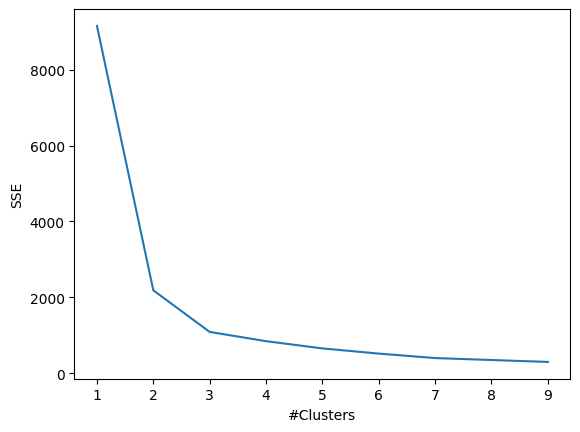

In [ ]:
#@title ELBOW CRITERION CODE
import matplotlib.pyplot as plt
sse = {}
for k in range(1, 10):
    clustering = KMeans(n_clusters=k, max_iter=1000,random_state=0, n_init=10).fit(scaled_data)
    sse[k] = clustering.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("#Clusters")
plt.ylabel("SSE")
plt.show()